# Lendo os dados e importando pacotes | *Reading the data and importing packages*

Image shape: (64, 64)


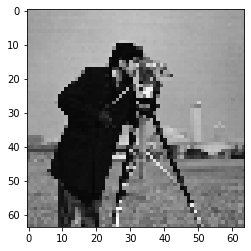

In [9]:
from ex1_utils import make_grid, are_vs_p_curve
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

# Reading and downsampling to 64x64
im = plt.imread("../resources/cameraman.tif")[::8, ::8]
plt.imshow(im, cmap='gray')

print("Image shape:", im.shape)

# Abordagem 1: grafo em grade com pesos unitátios | *Approach 1: grid graph with unit weights*

Decomposing L.
Inverting U.


100%|██████████| 82/82 [00:08<00:00,  9.11it/s]


Compression: 0.716796875


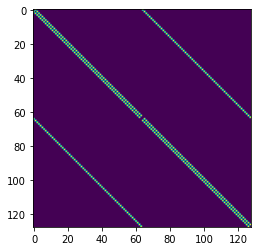

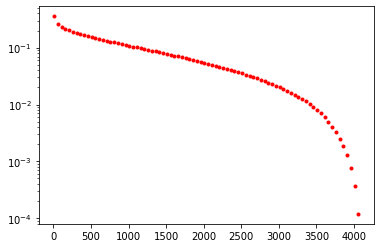

In [10]:
N, M = im.shape
A, coords = make_grid(N, M)
plt.figure()
plt.imshow(A[:128, :128])

p_values1, are_values1, smallest_p1, idx1 = are_vs_p_curve(im, A)
print("Compression:", (N*M - smallest_p1)/(N*M))

plt.figure()
plt.plot(p_values1, are_values1, 'r.', label="Abordagem 1")
plt.yscale("log")
plt.show()

# Abordagem 2: atualizando os pesos do grafo em grade para minimizar a variação total do sinal | *Approach 2: updating weights to minimize the graph signal total variation*

Iteration limit reached    (Exit mode 9)
            Current function value: 3902.1100674202185
            Iterations: 5
            Function evaluations: 644
            Gradient evaluations: 5
Successfull? False
Decomposing L.
Inverting U.


100%|██████████| 82/82 [00:10<00:00,  8.13it/s]

Compression: 0.85107421875


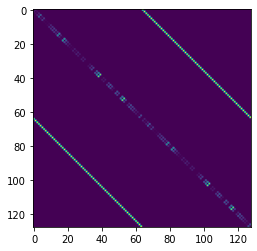

In [11]:
def total_variation_from_weights(weights, im):
    """Image signal total variation in a grid graph.

    The grid graph is built as a cartesian product between two path graphs,
    the weights of which are concatenated to form the `weights` input.
    Parameters
    ----------
    weights : array
        Concatenated weights of two path graphs. Its length equals
        N + M - 2, where N and M are taken from the shape of `im`.
    im : 2D array, shape=(N, M)
        Input image.

    """
    N, M = im.shape
    A, _ = make_grid(
        N, M, weights_r=weights[:(N-1)], weights_c=weights[(N-1):])
    x = im.ravel().reshape((N*M, 1))
    return np.linalg.norm(A @ x - x)

N, M = im.shape
rnd = np.random.RandomState(seed=2021)
# Initializing with gaussian random weights. If the initial weights are all
# equal, the optimizer has way more trouble finding an adjacency matrix
# on which the graph signal is smooth.
weights0 = 0.5 + 0.3 * rnd.randn(N-1 + M-1)
weights0[weights0 < 0] = 0

res = minimize(
    total_variation_from_weights, args=tuple([im]), x0=weights0,
    method='SLSQP',
    bounds=[(0, None) for i in range(len(weights0))],
    options=dict(disp=True, maxiter=5))

print("Successfull?", res.success)
weights = res.x

N, M = im.shape
A2, _ = make_grid(N, M, weights_r=weights[:(N-1)], weights_c=weights[(N-1):])
plt.figure()
plt.imshow(A2[:128, :128])

p_values2, are_values2, smallest_p2, idx2 = are_vs_p_curve(im, A2)
print("Compression:", (N*M - smallest_p2)/(N*M))

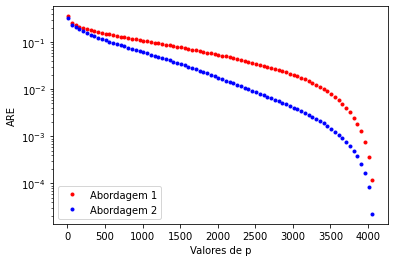

In [12]:
plt.figure()
plt.plot(p_values1, are_values1, 'r.', label="Abordagem 1")
plt.plot(p_values2, are_values2, 'b.', label="Abordagem 2")
plt.xlabel("Valores de p")
plt.ylabel("ARE")
plt.yscale("log")
plt.legend(loc="lower left")
plt.savefig("ex1_are_vs_p_v2.pdf", dpi=300)

In [13]:
N, M = im.shape
weights_naive = [1] * (N-1 + M-1)
print(
    "Total variation with unit weights:",
    total_variation_from_weights(weights_naive, im))

print(
    "Total variation with optimized weights:",
    total_variation_from_weights(weights, im))

Total variation with unit weights: 24754.72062052004
Total variation with optimized weights: 3902.1100674202185


In [14]:
print("Smallest p for ARE < 10% in Approach 1: {}. Compression: {}%".format(
    smallest_p1,
    100*(N*M - smallest_p1)/(N*M)))

print("Smallest p for ARE < 10% in Approach 2: {}. Compression: {}%".format(
    smallest_p2,
    100*(N*M - smallest_p2)/(N*M)))

Smallest p for ARE < 10% in Approach 1: 1160. Compression: 71.6796875%
Smallest p for ARE < 10% in Approach 2: 610. Compression: 85.107421875%
